<a href="https://colab.research.google.com/github/jiayuankeliang/309CourseWork2/blob/main/end_to_end.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files
files.upload()

{}

In [4]:
! mkdir ~/.kaggle

In [5]:
! cp kaggle.json ~/.kaggle/

In [6]:
! chmod 600  ~/.kaggle/kaggle.json

In [7]:
!kaggle datasets download meowmeowmeowmeowmeow/gtsrb-german-traffic-sign

100% 611M/612M [00:32<00:00, 19.9MB/s]
100% 612M/612M [00:32<00:00, 19.8MB/s]


In [8]:
import zipfile

filename = '/content/gtsrb-german-traffic-sign.zip'

with zipfile.ZipFile(filename, 'r') as zip_ref:
  zip_ref.extractall('.')

In [9]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd

In [10]:
batch_size = 32
img_height = 32
img_width = 32

In [11]:
train_set = tf.keras.utils.image_dataset_from_directory(
  '/content/Train',
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 31368 files for training.


In [12]:
val_set = tf.keras.utils.image_dataset_from_directory(
  '/content/Train',
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 39209 files belonging to 43 classes.
Using 7841 files for validation.


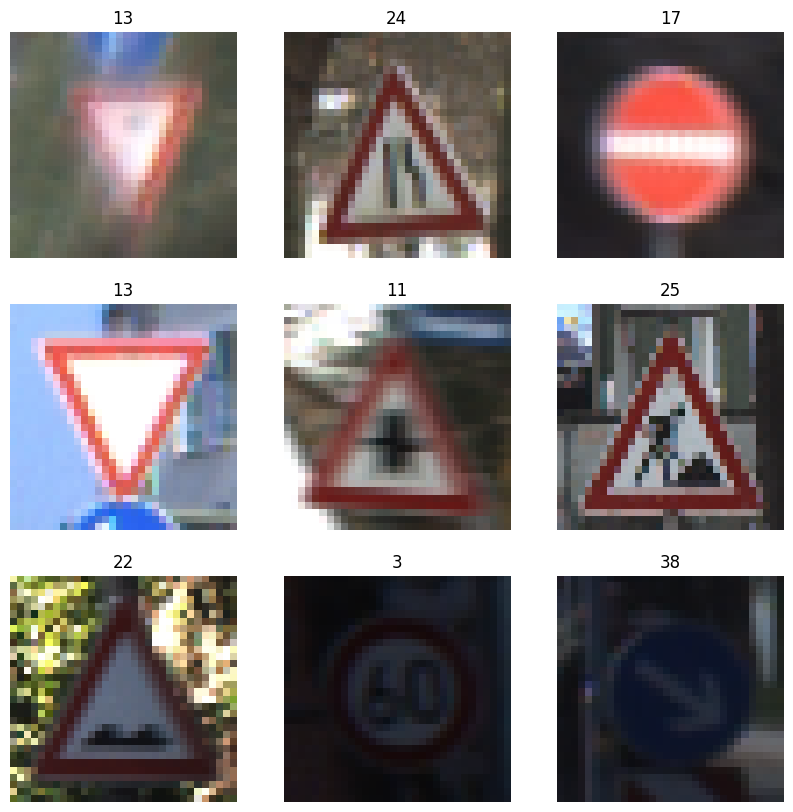

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_set.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(labels[i])
    plt.axis("off")

In [15]:
for image_batch, labels_batch in train_set:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 32, 32, 3)
(32,)


In [16]:
resize_and_rescale = tf.keras.Sequential([
    tf.keras.layers.Resizing(img_height, img_width),
    tf.keras.layers.Rescaling(1./255)
])

In [30]:
num_classes = 43

model = tf.keras.Sequential([
    resize_and_rescale,

    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(filters=256, kernel_size=(3,3), activation='relu', padding='same'),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),

    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(rate=0.5),
    
    tf.keras.layers.Dense(num_classes, activation='softmax')
])


In [32]:
model.compile(
  optimizer='adam',
  loss='sparse_categorical_crossentropy',
  metrics=['accuracy'])

In [33]:
model.fit(
  train_set,
  validation_data=val_set,
  epochs=10
)

Epoch 1/10
981/981 [==============================] - 17s 15ms/step - loss: 1.6847 - accuracy: 0.5008 - val_loss: 0.1897 - val_accuracy: 0.9494
Epoch 2/10
981/981 [==============================] - 14s 14ms/step - loss: 0.2330 - accuracy: 0.9284 - val_loss: 0.0452 - val_accuracy: 0.9893
Epoch 3/10
981/981 [==============================] - 14s 15ms/step - loss: 0.1041 - accuracy: 0.9697 - val_loss: 0.0443 - val_accuracy: 0.9888
Epoch 4/10
981/981 [==============================] - 14s 15ms/step - loss: 0.0760 - accuracy: 0.9778 - val_loss: 0.0219 - val_accuracy: 0.9955
Epoch 5/10
981/981 [==============================] - 14s 15ms/step - loss: 0.0549 - accuracy: 0.9848 - val_loss: 0.0372 - val_accuracy: 0.9921
Epoch 6/10
981/981 [==============================] - 14s 14ms/step - loss: 0.0542 - accuracy: 0.9844 - val_loss: 0.0262 - val_accuracy: 0.9941
Epoch 7/10
981/981 [==============================] - 15s 15ms/step - loss: 0.0436 - accuracy: 0.9877 - val_loss: 0.0361 - val_accuracy:

In [41]:
# testing accuracy on test dataset
from sklearn.metrics import accuracy_score
from PIL import Image

# Importing the test dataset
y_test = pd.read_csv('/content/Test.csv')

labels = y_test["ClassId"].values
imgs = y_test["Path"].values

data=[]

# Retreiving the images
with tf.device('/GPU:0'):
    for img in imgs:
        image = Image.open('/content/'+img)
        image = image.resize([32, 32])
        data.append(np.array(image))

X_test=np.array(data)

In [43]:
model.evaluate(X_test, labels)

395/395 [==============================] - 2s 4ms/step - loss: 4.1898 - accuracy: 0.0309


[4.189760684967041, 0.030878860503435135]